<a href="https://colab.research.google.com/github/livalgo/interactive-pipe-examples/blob/main/interactive_pipe_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⏯ [`interactive_pipe` website](https://balthazarneveu.github.io/interactive_pipe/)

![](https://balthazarneveu.github.io/interactive_pipe/static/interact-pipe-logo-horizontal-rgb.svg)


# Full tutorial

**Note** : The same tutorial is also available on [🤗 HF spaces](https://huggingface.co/spaces/balthou/interactive-pipe-tutorial)

In [1]:
# Mandatory installation.
!pip install "ipywidgets>=7,<8"
!pip install interactive-pipe>=0.7.8

In [2]:
from interactive_pipe.data_objects.curves import Curve, SingleCurve
from interactive_pipe import interactive, interactive_pipeline
from interactive_pipe.helper import _private

import numpy as np

In [59]:
# "Production code"

# -----------------
# Processing blocks
# -----------------


def gen_color(
    frequency: int = 0,  # discrete slider (int)
    isotropy: float = 0.,  # continuous slider (float)
    context={}  # global parameters (dict)
) -> np.ndarray:
    # context allows sharing information between processing blocks.
    # Let's share the frequency value for further use.
    context["freq"] = frequency
    # print(context.get("initialized_param", "Wrongly initialized context!"))
    lin_coord = np.linspace(0, 1., 256)
    X, Y = np.meshgrid(lin_coord, isotropy*lin_coord)
    radius = 0.5+0.5*np.cos(frequency*np.sqrt(X**2 + Y**2))
    return np.stack([np.abs(X), np.abs(Y), radius], axis=-1).clip(0, 1)


def modify_geometry(
    img: np.ndarray,
    effect: str = "flip"  # dropdown menus (str)
) -> np.ndarray:
    img = img[::-1] if "flip" in effect else img
    img = img[:, ::-1] if "mirror" in effect else img
    return img


def change_color(
    img: np.ndarray,
    bnw: bool = True  # checkboxes (bool)
):
    if bnw:
        return np.mean(img, axis=-1, keepdims=True).repeat(3, axis=-1)
    return img


def compare_by_splitting(
    img_1: np.ndarray,
    img_2: np.ndarray,
    ratio: float = 0.5,  # continuous slider (float)
) -> np.ndarray:
    out = np.zeros_like(img_1)
    split = int(ratio*img_1.shape[1])
    out[:, :split] = img_2[:, :split]
    out[:, split+5:] = img_1[:, split+5:]
    return out


def extract_profile(img: np.ndarray, context={}) -> Curve:
    # context allows sharing information between processing blocks
    frequency = context.get('freq', 0)
    init_shared_param = context.get(
        'initialized_param', "Wrongly initialized context!")
    luma = img.mean(axis=-1)
    h_profile = SingleCurve(
        y=luma[0, :], label=f"H profile f={frequency}")
    v_profile = SingleCurve(y=luma[:, 0], label="V profile")
    return Curve(
        [h_profile, v_profile],
        xlabel="Position", ylabel="Luminance",
        ylim=(0, 1),
        grid=True,
        title=f"Luminance profiles ({init_shared_param})"
    )

# -------------------
# Pipeline definition
# -------------------


def tutorial_pipeline():
    inp = gen_color()
    out_geometry = modify_geometry(inp)
    out_bnw = change_color(inp)
    out_image = compare_by_splitting(out_geometry, out_bnw)
    out_profile = extract_profile(out_image)
    return [[inp, out_geometry], [out_profile, out_image]]
    # return [out_profile, out_image]
    # return [inp, out_geometry, out_profile, out_image]


In [60]:
# Add interactivity
# --------------------------------------------------------------


def add_interactivity() -> None:
    # Depending on the level of control you want,
    # you can add more or less controls to the pipeline
    # (hide some sliders if you want!)
    interactive(
        ratio=(0.5, [0., 1.], "Side by Side comparison")
    )(compare_by_splitting)
    interactive(
        bnw=(True, "Black and White")
    )(change_color)
    interactive(
        effect=("flip", ["flip", "mirror", "flip+mirror", "identity"])
    )(modify_geometry)
    interactive(
        frequency=(80, [1, 100]),
        isotropy=(0.8, [0.1, 1.])
    )(gen_color)


def run_interactive_pipeline(
    backend: str = "gradio",
    markdown_description: str = "# Tuto"
) -> None:
    add_interactivity()
    interactive_pipeline(
        gui=backend,
        cache=True,
        context={"initialized_param": 42},
        size=(12, 4)
        # context is shared between processing blocks.
        # Initialization allow to pre-load a neural network for example.
    )(tutorial_pipeline)()



interactive(children=(IntSlider(value=80, description='frequency', layout=Layout(width='500px'), min=1, style=…

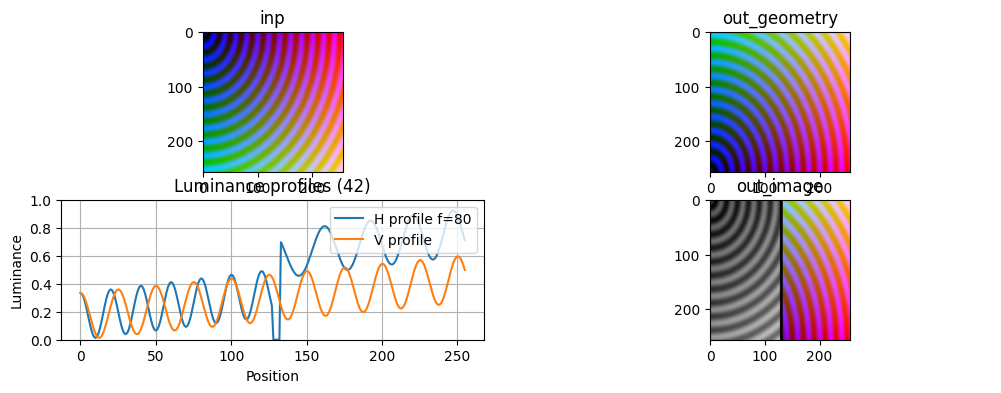

In [61]:
_private.registered_controls_names = [] # this is for notebooks where you re-execute cells everytime.
run_interactive_pipeline(backend="nb", markdown_description="# Tutorial");
# Please note that you may get 2 figures...
# This is an issue with notebooks without easy workarounds.
# Prefer backends such as Qt to avoid such issues
# and control all aspects of graphical interface!


# Advice

-----

## Keep separation between "production code" (library / not interactive) & interactivity

- 💡 One of the strength of interactive pipe is to avoid adding hundreds of lines of code dedicated to GUI (graphical user interfaces).
- With interactive pipe, you have the choice to keep this design choice. Each processing block can be defined as a regular function, without even importing the `interactive` decorator. In a separate file, you'll add sliders.


### Several ways to decorate building blocks


#### 1.Decorate afterward   🏆 *= Recommended approach*
- ➖ Less elegant to read (`add_interactivity` may be in a different file)
- ➕ The original function can be re-used somewhere else before being decorated.
- ➕ Possibility to add conditions (`debug` flag)

```python
def gen_color(frequency=0, isotropy=0.):
    ...


def add_interactivity(debug=True):
    interactive(
        frequency=(80, [1, 100]),
        isotropy=(0.8, [0.1, 1.]) if debug else 0.8
    )(gen_color)
```


#### 2.Decorate using `@`


```python
@interactive(
    frequency=(80, [1, 100]),
    isotropy=(0.8, [0.1, 1.])
)
def gen_color(frequency=0, isotropy=0.):
    ...
```
- ➕ Easy to read
- ➖ The decorated function can't be re-used somewhere else.
- ➖ No possibility to add condition to hide/show slider. To hide the slider, you need to comment!


#### 3. Shorter code using `@`

```python
@interactive()
def gen_color(
    frequency=(80, [1, 100]),
    isotropy=(0.8, [0.1, 1.])
):
```

- ➕ Shortest code
- ➖ The decorated function can't be re-used somewhere else


------------


## Pipeline visualization
Internally, `interactive_pipe` builds an execution graph of the pipeline.

| pipeline's execution graph |
| :--:|
| ![Pipeline](https://huggingface.co/spaces/balthou/interactive-pipe-tutorial/resolve/main/pipeline.png) |

----


## Backend choice

|Backend | 🚀  `Qt` | 🐢 `Gradio` | 🐢 `Notebooks`
|:---|:---|:---|:---|
| Responsiveness | ➕ Very fast | ➖ Slower  | ➖ Slower  |
| Shareable | ➖ No, only 1 local Qt Window | ➕ Share a link with others | ➕ Share  on colab |
| Sharing platform | ➖  | ➕  standalone hosting on  HF spaces 🤗 | ➕ Share  on colab |
| Keyboard controls |  ➕ Yes | ➖ No | ➖ No |
| Full screen |  ➕ Yes | ➖ No | ➖ No |
| Image compression |  ➕ No image compression | ➖ Some image compression | ➕ No image compression |


| 🚀  `Qt` | 🐢 `Gradio` |
|:---:|:---:|
| ![QT](https://huggingface.co/spaces/balthou/interactive-pipe-tutorial/resolve/main/pyqt.gif) | ![Gradio](https://huggingface.co/spaces/balthou/interactive-pipe-tutorial/resolve/main/gradio.gif) |